In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Read data
file_path = 'data/btc_krw_converted.csv'
df = pd.read_csv(file_path)

# Rename columns to match the specified format
df.columns = ['timestamp', 'Exchange Rate', 'close', 'open', 'high', 'low', 'volume', 'change']

# Calculate price change
df['change'] = df['close'].pct_change() * 100

# Drop the first row (which will have NaN change due to pct_change())
df = df.dropna()

# Select the 'close' price for prediction
data = df['close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create dataset for LSTM input
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Use the past 5 days' data to predict the next day's value
look_back = 5
X, y = create_dataset(scaled_data, look_back)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for LSTM input: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print shapes for confirmation
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training data shape: (1638, 5, 1), Training labels shape: (1638,)
Validation data shape: (546, 5, 1), Validation labels shape: (546,)
Testing data shape: (547, 5, 1), Testing labels shape: (547,)


In [5]:
from keras.optimizers.schedules import ExponentialDecay


# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))  # Add 1D Convolutional Layer
model.add(MaxPooling1D(pool_size=2))  # Add MaxPooling Layer

# Add LSTM Layer
model.add(LSTM(units=64, activation='tanh'))

model.add(Flatten())  # Flatten the input for the Dense layer
model.add(Dense(32, activation='relu'))  # Add Dense Layer with ReLU activation
model.add(Dense(1, activation='linear'))

# 모델 요약 출력
model.summary()

# 초기 학습률과 학습률 감소 설정
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)

# 옵티마이저에 학습률 스케줄 적용
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 모델 컴파일
delta_value = 1.0
model.compile(optimizer=optimizer,
                       loss=tf.keras.losses.Huber(delta=delta_value),
                       metrics=['mae', 'mape'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2, 64)             0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                      

In [6]:
import tensorflow as tf
from keras.callbacks import Callback
from keras.optimizers.schedules import ExponentialDecay

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if hasattr(lr, 'numpy'):  # 핸들링 tf.Variable 또는 Keras decay
            lr_value = lr.numpy()
        else:
            lr_value = tf.keras.backend.get_value(lr)
        print(f" - learning rate:  {lr:.g}")

# Train the model
per_worker_batch_size = 32
num_workers = 1
global_batch_size = per_worker_batch_size * num_workers
epoch = 100

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=epoch,
    batch_size=global_batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_mape',
                                         patience=500,
                                         restore_best_weights=True),
    ],

    use_multiprocessing=True,
    workers=num_workers,
    verbose=1
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


Epoch 1/100
52/52 [==============================] - 2s 15ms/step - loss: 0.0086 - mae: 0.0832 - mape: 428.9908 - val_loss: 2.9052e-04 - val_mae: 0.0190 - val_mape: 54725.4727
Epoch 2/100
52/52 [==============================] - 0s 6ms/step - loss: 1.4055e-04 - mae: 0.0119 - mape: 58.4851 - val_loss: 1.2956e-04 - val_mae: 0.0104 - val_mape: 32520.6953
Epoch 3/100
52/52 [==============================] - 0s 6ms/step - loss: 9.9689e-05 - mae: 0.0090 - mape: 136.6340 - val_loss: 1.2254e-04 - val_mae: 0.0093 - val_mape: 21608.7812
Epoch 4/100
52/52 [==============================] - 0s 6ms/step - loss: 9.2083e-05 - mae: 0.0084 - mape: 92.0025 - val_loss: 1.1647e-04 - val_mae: 0.0095 - val_mape: 15765.6572
Epoch 5/100
52/52 [==============================] - 0s 6ms/step - loss: 9.0408e-05 - mae: 0.0082 - mape: 101.5364 - val_loss: 1.0882e-04 - val_mae: 0.0089 - val_mape: 17335.1504
Epoch 6/100
52/52 [==============================] - 0s 6ms/step - loss: 9.1527e-05 - mae: 0.0084 - mape: 86.9

In [7]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

18/18 [==============================] - 0s 2ms/step


In [8]:
# In the scaling of predictions to original values
train_predict_scaled = scaler.inverse_transform(train_predict)
test_predict_scaled = scaler.inverse_transform(test_predict)
y_train_scaled = scaler.inverse_transform([y_train])
y_test_scaled = scaler.inverse_transform([y_test])


In [9]:
# Adjust the shape of y_train and y_test
y_train_scaled = y_train_scaled.reshape(-1, 1)
y_test_scaled = y_test_scaled.reshape(-1, 1)


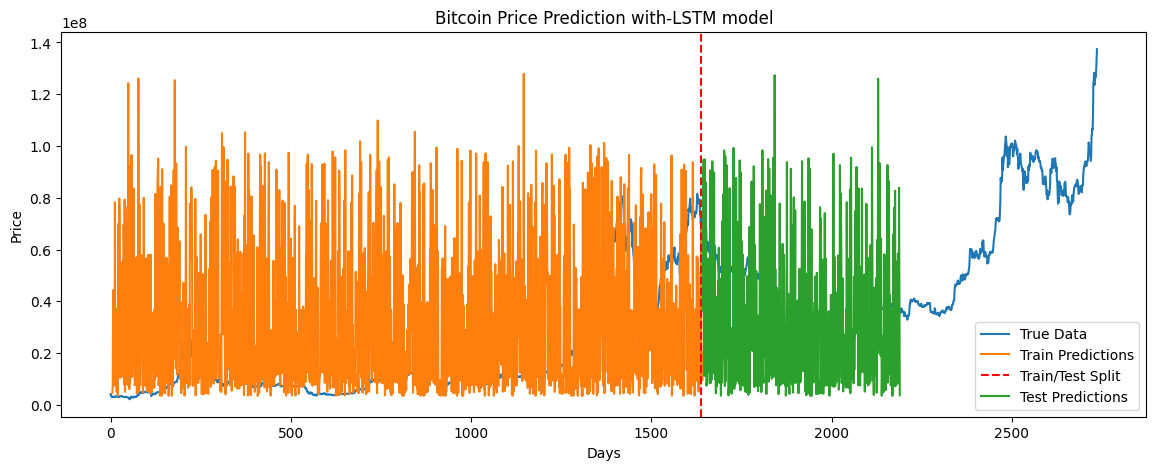

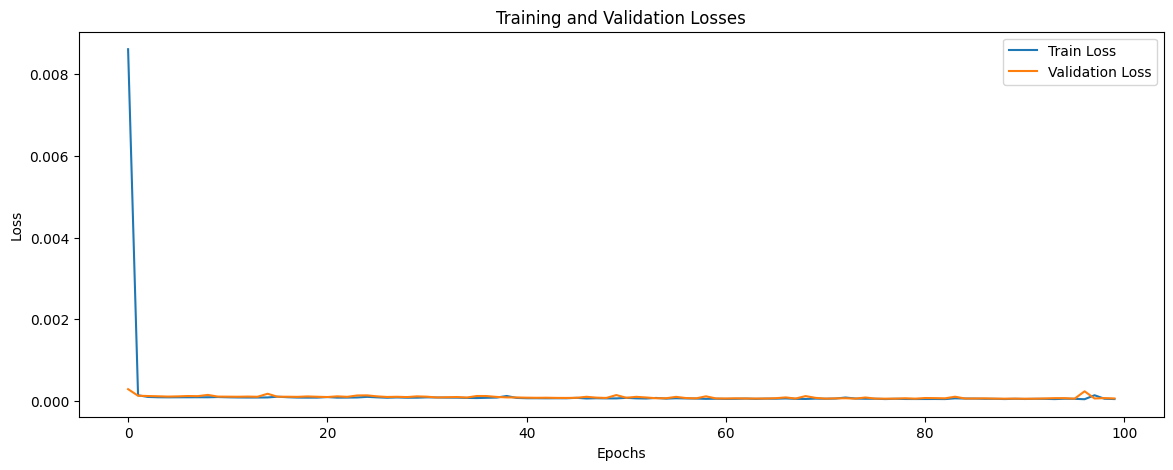

In [10]:


# Plotting the training data predictions
plt.figure(figsize=(14, 5))
plt.plot(data, label='True Data')
plt.plot(range(look_back, len(train_predict_scaled) + look_back), train_predict_scaled, label='Train Predictions')
plt.axvline(x=len(train_predict_scaled), color='r', linestyle='--', label='Train/Test Split')
plt.plot(range(len(train_predict_scaled) + look_back, len(train_predict_scaled) + look_back + len(test_predict_scaled)), test_predict_scaled, label='Test Predictions')
plt.title('Bitcoin Price Prediction with-LSTM model')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting the losses during training
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model on the training data
train_loss = model.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {train_loss}")

# Evaluate the model on the testing data
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Testing Loss: {test_loss}")

52/52 [==============================] - 0s 3ms/step - loss: 4.8136e-05 - mae: 0.0059 - mape: 87.3452
Training Loss: [4.813628765987232e-05, 0.005907144397497177, 87.34516906738281]
18/18 [==============================] - 0s 3ms/step - loss: 7.0030e-05 - mae: 0.0065 - mape: 5.4328
Testing Loss: [7.003007340244949e-05, 0.006498224101960659, 5.432844161987305]
